# Introduction
Method for automatically determining optimal camouflage colors by using machine learning.



<IPython.core.display.Javascript object>


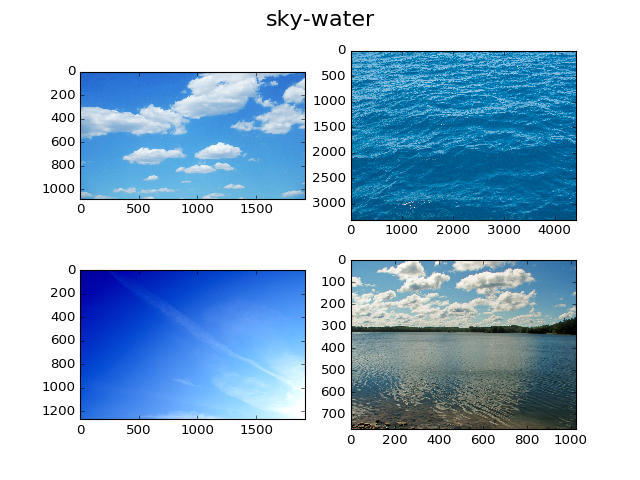

<IPython.core.display.Javascript object>


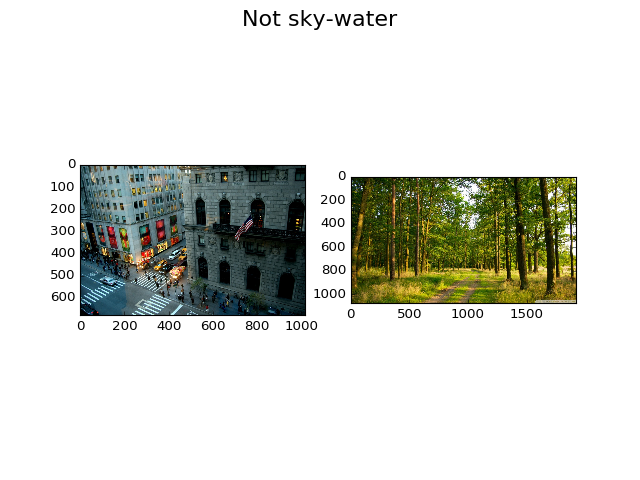

In [13]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
from skimage import io
from sklearn.utils import shuffle

ic_sky = io.imread_collection("sky/*")
ic_not_sky = io.imread_collection("not-sky/*")

def plot_images(image_collection, label):
    fig, axes = plt.subplots(math.ceil(len(image_collection)/2), 2)
    fig.suptitle(label, fontsize=20)
    for idx, img in enumerate(image_collection):
        row = idx % 2
        col = idx // 2
        if len(image_collection) > 2:
            axes[row,col].imshow(img)
        else:
            axes[row].imshow(img)

plot_images(ic_sky, "sky-water")
plot_images(ic_not_sky, "Not sky-water")

def create_labeled_pixels(image_collection, label):
    pixels = []
    for img in image_collection:
        w, h, d = original_shape = tuple(img.shape)
        assert d == 3
        image_array = np.reshape(img, (w * h, d))    
        pixels.append(image_array)
    data = np.concatenate(pixels)
    labels = np.full(data.shape[0], label)
    return data, labels

sky_data, sky_labels = create_labeled_pixels(ic_sky, 1)
not_sky_data, not_sky_labels = create_labeled_pixels(ic_not_sky, 0)
data = np.concatenate([sky_data, not_sky_data])
labels = np.concatenate([sky_labels, not_sky_labels])
# print(data.shape, labels.shape)

# randomly select n number of pixels to train model
n = 100000
data_subset, labels_subset = shuffle(data, labels, random_state=0, n_samples=n)
# print(data_subset.shape, labels_subset.shape)

<IPython.core.display.Javascript object>


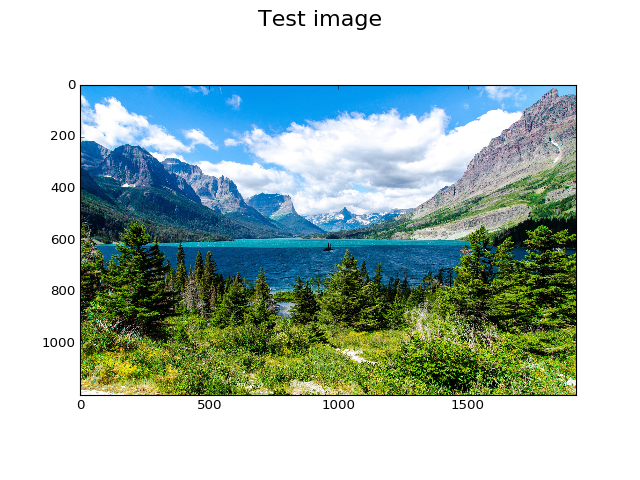

In [14]:
test_img = io.imread("test-images/mountains_nature.jpg")
# test_img = io.imread("test-images/forest_river.jpg")
plt.figure()
plt.suptitle("Test image", fontsize=20)
plt.imshow(test_img)
w, h, d = original_shape = tuple(test_img.shape)
test_img_array = np.reshape(test_img, (w * h, d))
# print(original_shape, test_img.dtype)


<IPython.core.display.Javascript object>


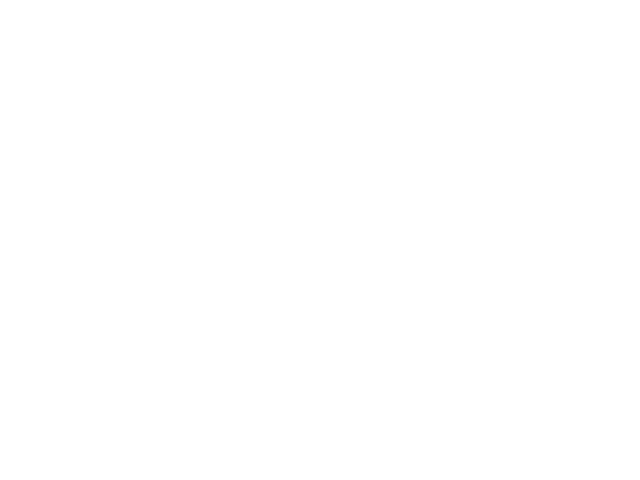

In [4]:
from sklearn import svm
clf = svm.SVC(gamma=0.001, C=100.) # classifier, must be fitted to a model
clf.fit(data_subset, labels_subset)
pred = clf.predict(test_img_array)
pred_img = pred.reshape((w,h))
plt.figure()
plt.suptitle("SVM", fontsize=20)
plt.imshow(pred_img, cmap="Greys")

<IPython.core.display.Javascript object>


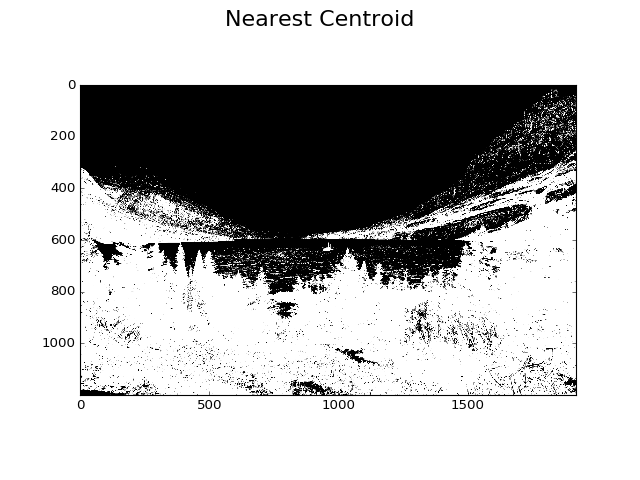

<IPython.core.display.Javascript object>


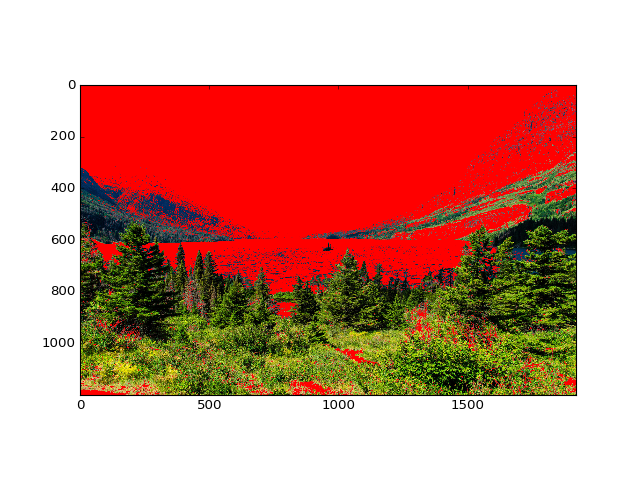

In [15]:
from sklearn.neighbors.nearest_centroid import NearestCentroid
nc = NearestCentroid()
nc.fit(data_subset, labels_subset)
pred = nc.predict(test_img_array)
pred_img = pred.reshape((w,h))
plt.figure()
plt.suptitle("Nearest Centroid", fontsize=20)
plt.imshow(pred_img, cmap="Greys")

masked = test_img_array.copy()
masked[np.where(pred > 0)] = [255,0,0]
masked_img = masked.reshape(original_shape)
plt.figure()
plt.imshow(masked_img)



<IPython.core.display.Javascript object>


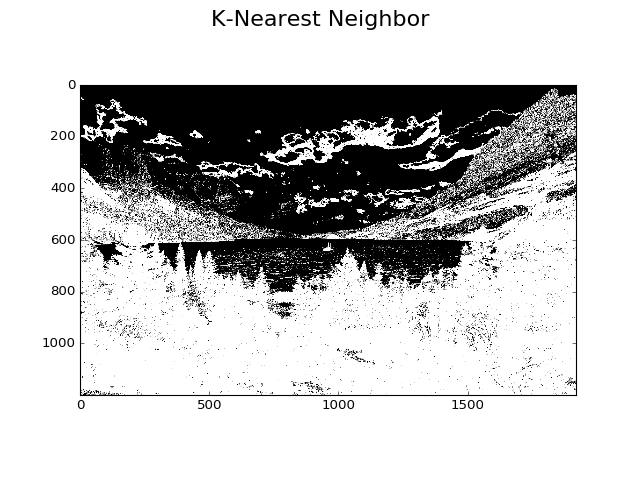

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.externals import joblib
knn = KNeighborsClassifier()
knn.fit(data_subset, labels_subset) 
pred = knn.predict(test_img_array)
pred_img = pred.reshape((w,h))
plt.figure()
plt.suptitle("K-Nearest Neighbor", fontsize=20)
plt.imshow(pred_img, cmap="Greys")
# joblib.dump(knn, 'dcs_knn.pkl')  # save model

<IPython.core.display.Javascript object>


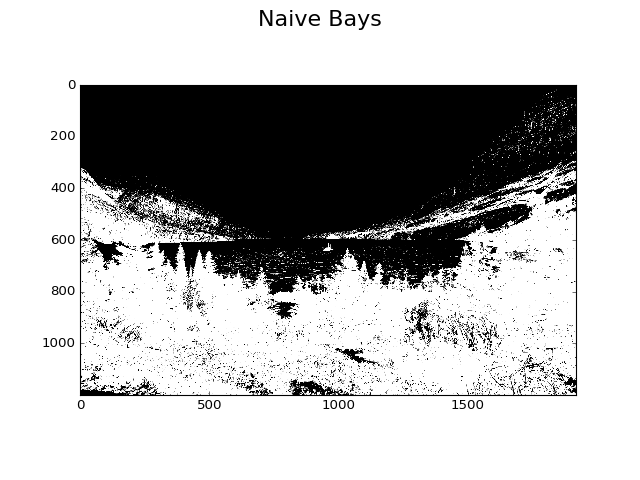

In [17]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(data_subset, labels_subset)
pred = clf.predict(test_img_array)
pred_img = pred.reshape((w,h))
plt.figure()
plt.suptitle("Naive Bays", fontsize=20)
plt.imshow(pred_img, cmap="Greys")

<IPython.core.display.Javascript object>


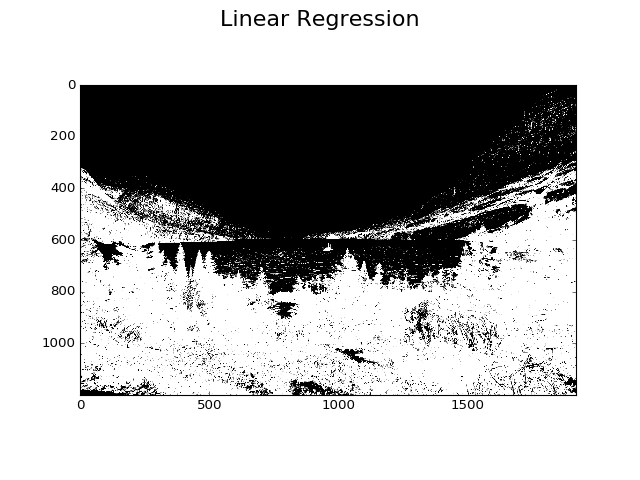

In [18]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(data_subset, labels_subset)
pred = clf.predict(test_img_array)
pred_img = pred.reshape((w,h))
plt.figure()
plt.suptitle("Linear Regression", fontsize=20)
plt.imshow(pred_img, cmap="Greys")

<IPython.core.display.Javascript object>


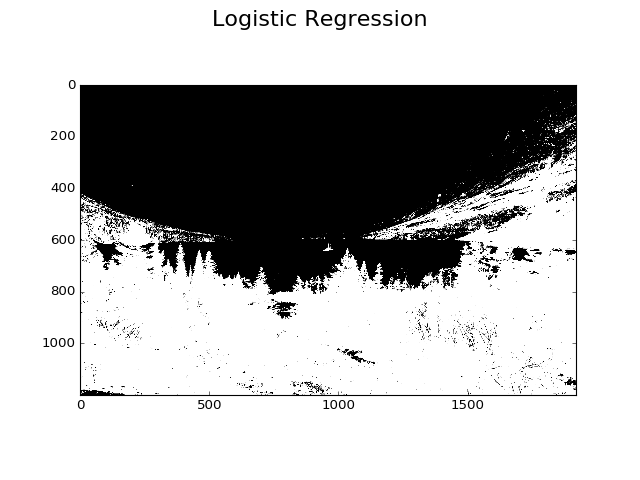

In [19]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(data_subset, labels_subset)
pred = clf.predict(test_img_array)
pred_img = pred.reshape((w,h))
plt.figure()
plt.suptitle("Logistic Regression", fontsize=20)
plt.imshow(pred_img, cmap="Greys")


Fitting model on a small sub-sample of the data
done in 0.118s.
Predicting color indices on the full image (k-means)
done in 0.210s.


<IPython.core.display.Javascript object>


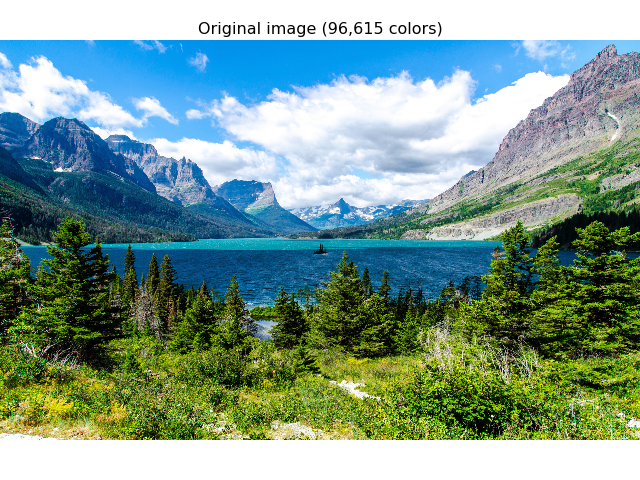

<IPython.core.display.Javascript object>


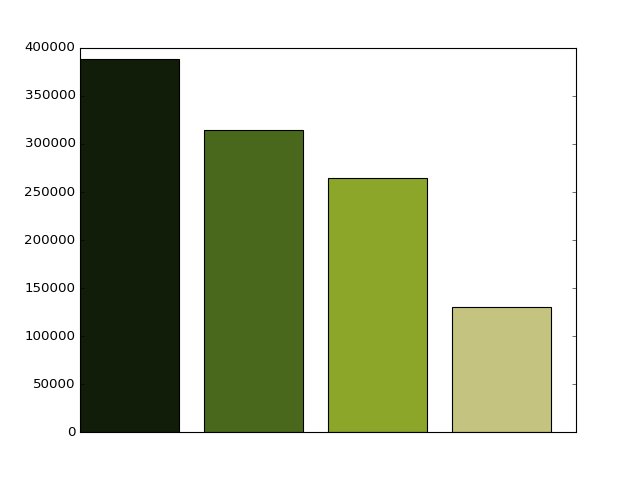

<Container object of 4 artists>

In [20]:
#http://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from time import time

n_colors = 4
filter_out = True

# Convert to floats instead of the default 8 bits integer coding. Dividing by
# 255 is important so that plt.imshow behaves works well on float data (need to
# be in the range [0-1])
if filter_out:
    # filter out sky pixels
    image_array = np.array(test_img_array[np.where(pred < 1)], dtype=np.float64) / 255
else:
    image_array = np.array(test_img_array, dtype=np.float64) / 255


print("Fitting model on a small sub-sample of the data")
t0 = time()
image_array_sample = shuffle(image_array, random_state=0)[:1000]
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
print("done in %0.3fs." % (time() - t0))

# Get labels for all points
print("Predicting color indices on the full image (k-means)")
t0 = time()
labels = kmeans.predict(image_array)
print("done in %0.3fs." % (time() - t0))

# Display all results, alongside original image
plt.figure()
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Original image (96,615 colors)')
plt.imshow(test_img)


# plt.figure()
# plt.clf()
# ax = plt.axes([0, 0, 1, 1])
# plt.axis('off')
# plt.title('Quantized image (%i colors, K-Means)' % n_colors)
# plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

# plt.figure()
# plt.imshow(kmeans.cluster_centers_.reshape(n_colors,1,3))

# sort pallete collors based on occurance
sorted_idx = np.argsort(np.bincount(labels))[::-1]
sorted_labels = np.bincount(labels)[sorted_idx]
palette = np.array(kmeans.cluster_centers_*256, dtype=np.uint8)
palette = palette[sorted_idx]

plt.figure()
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off
plt.bar(np.arange(n_colors), sorted_labels, color=palette/256)


# #np.savetxt("kmeans.gpl", palette, delimiter=" ", fmt="%i")
# print("GIMP Palette \n\
# Name: kmeans \n\
# Columns: 0 \n\
# #     ")
# for row in palette:
#     print("%s" % (" ".join("%03s" % i for i in row)))

<IPython.core.display.Javascript object>


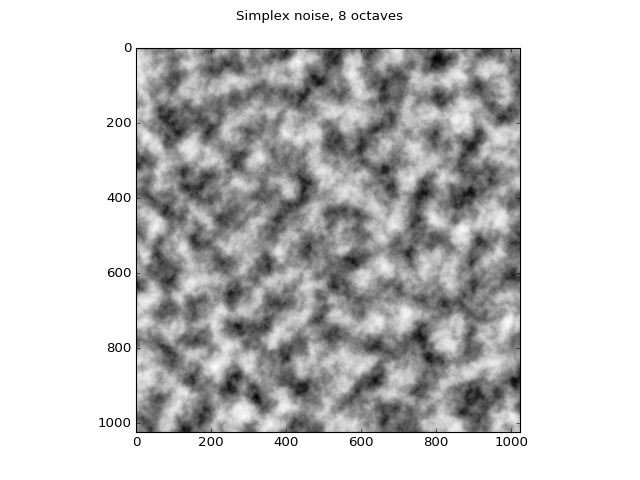

<IPython.core.display.Javascript object>


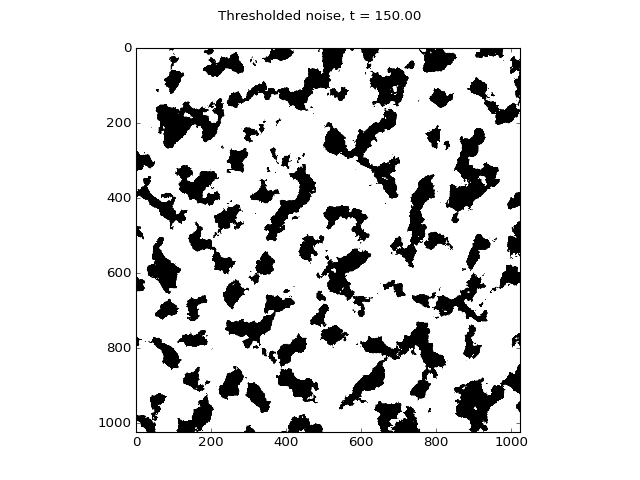

<IPython.core.display.Javascript object>


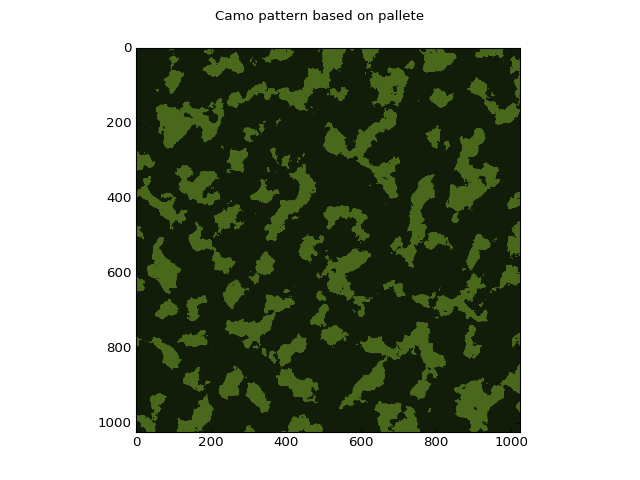

bool


<IPython.core.display.Javascript object>


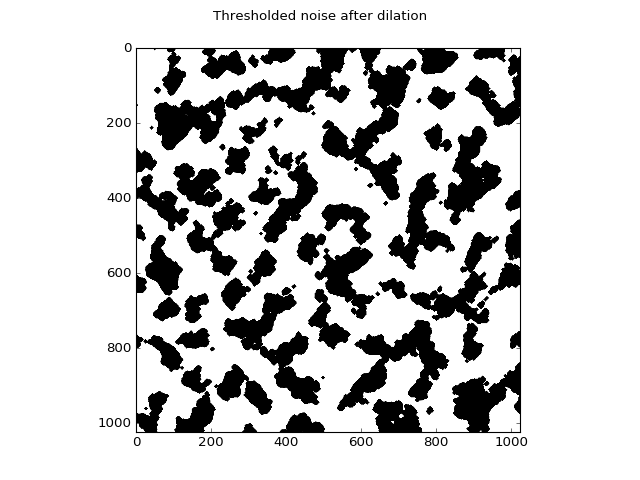

<IPython.core.display.Javascript object>


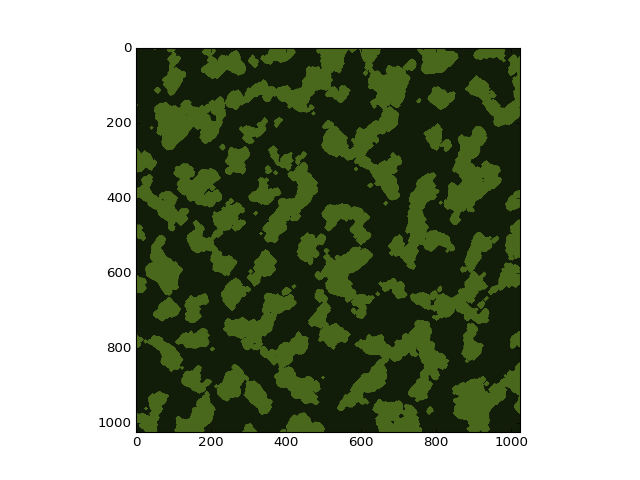

bool


<IPython.core.display.Javascript object>


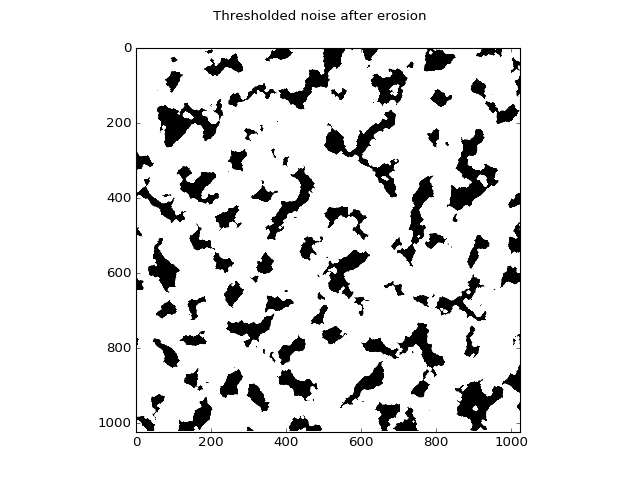

<IPython.core.display.Javascript object>


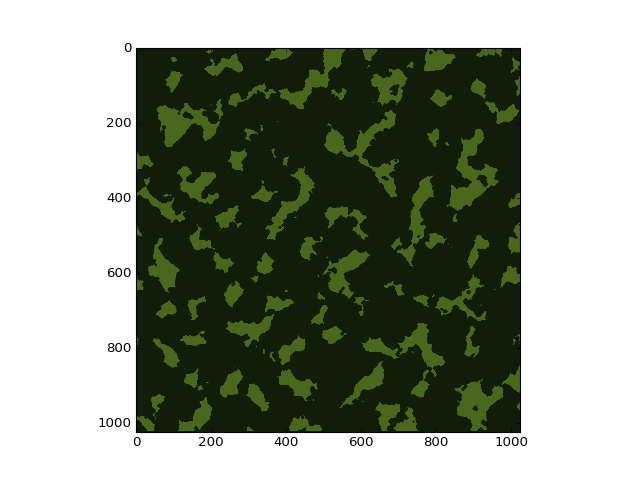

In [21]:
from noise import pnoise2, snoise2

octaves = 8
freq = 16.0 * octaves
noise = []
size = 1024
for x in range(size):
    for y in range(size):
        noise.append(int(snoise2(x / freq, y / freq, octaves) * 127.0 + 128.0)) # 2D simplex noise
noise = np.array(noise)
thresh_noise = noise.copy()
# threshold
t = 150
thresh_noise[np.where( noise < t)] = 0
thresh_noise[np.where( noise >= t)] = 255

noise = noise.reshape((size,size))
thresh_noise = thresh_noise.reshape((size,size))


plt.figure()
plt.suptitle("Simplex noise, %i octaves" % octaves)
plt.imshow(noise, cmap='Greys')

plt.figure()
plt.suptitle("Thresholded noise, t = %0.2f" % t)
plt.imshow(thresh_noise, cmap='Greys')

bg_color = palette[0]
c_color = palette[1]
camo = np.full((size,size,3),  bg_color, dtype=np.uint8)
camo[np.where( thresh_noise > 100)] = c_color

plt.figure()
plt.suptitle("Camo pattern based on pallete")
plt.imshow(camo)

from scipy.ndimage.morphology import binary_dilation
from scipy.ndimage.morphology import binary_erosion

thresh_noise2 = binary_dilation(thresh_noise, iterations=5)
print(thresh_noise2.dtype)
plt.figure()
plt.suptitle("Thresholded noise after dilation")
plt.imshow(thresh_noise2, cmap='Greys')

camo = np.full((size,size,3),  bg_color, dtype=np.uint8)
camo[np.where( thresh_noise2 )] = c_color

plt.figure()
plt.imshow(camo)

thresh_noise3 = binary_erosion(thresh_noise, iterations=3)
print(thresh_noise3.dtype)
plt.figure()
plt.suptitle("Thresholded noise after erosion")
plt.imshow(thresh_noise3, cmap='Greys')

camo = np.full((size,size,3),  bg_color, dtype=np.uint8)
camo[np.where( thresh_noise3 )] = c_color

plt.figure()
plt.imshow(camo)
